Computing gradients.
Computing median gradients.


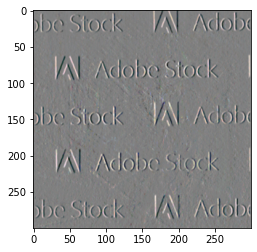

In [1]:
import cv2
from src.estimate_watermark import *
from src.preprocess import *
from src.image_crawler import *
from src.watermark_reconstruct import *

train_pth = 'multiple/train/'
test_pth = 'multiple/test/'
result_pth = 'multiple/result_test/'

gx, gy, gxlist, gylist = estimate_watermark(train_pth+'watermarked')
plt.imshow(PlotImage(gx))
plt.draw()

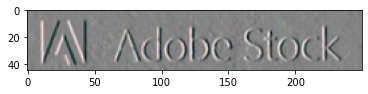

In [2]:
# set start position and end position manually and crop gx & gy
sx=55
ex=100
sy=20
ey=270
lx=ex-sx
ly=ey-sy
cropped_gx = gx[sx:ex,sy:ey,:]
cropped_gy = gy[sx:ex,sy:ey,:]
plt.imshow(PlotImage(cropped_gx))
plt.draw()

In [3]:
# ------------------------------- train ----------------------------------

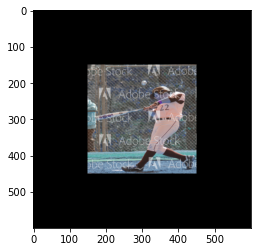

In [4]:
# add border
img_shape = (300,300)

z = np.zeros([img_shape[0]*2,img_shape[1]*2,3])
im = np.zeros([img_shape[0]*2,img_shape[1]*2,3]).astype( np.uint8 )

# select a random image
img = cv2.imread(train_pth+'watermarked/1.png')
im[int(img_shape[0]/2):int(3*img_shape[0]/2), int(img_shape[1]/2):int(3*img_shape[1]/2)] = img[0:img_shape[0],0:img_shape[1]]

plt.imshow(PlotImage(im))
plt.show()

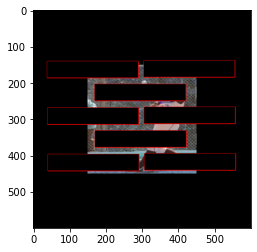

[(204, 170), (332, 171), (395, 307), (141, 39), (139, 305), (269, 40), (397, 41), (267, 306)]


In [5]:
# Input number of watermarks manually
num_w = 8
s = []
lx = cropped_gx.shape[0]
ly = cropped_gx.shape[1]

for i in range(num_w):
    im, s1, l1 = watermark_detector(im, cropped_gx, cropped_gy)
    s.append(s1)
    im[s[i][0]:s[i][0]+lx,s[i][1]:s[i][1]+ly] = z[s[i][0]:s[i][0]+lx,s[i][1]:s[i][1]+ly]
plt.imshow(im)
plt.show()
print(s)

In [6]:
num_images = len(gxlist)
print("num_images =",num_images)

# crop images and add it to our matrix
J,file_names = get_cropped_images(
    train_pth+'watermarked', num_images, 2, s, cropped_gx.shape)

num_images = 5


Computing gradients.
Computing median gradients.


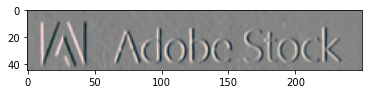

In [7]:
# compute grads again

# Compute grads for all images in J
print("Computing gradients.")
gradx = list(map(lambda x: cv2.Sobel(x, cv2.CV_64F, 1, 0, ksize=KERNEL_SIZE), J))
grady = list(map(lambda x: cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=KERNEL_SIZE), J))

# Compute median of grads
print("Computing median gradients.")
Wm_x = np.median(np.array(gradx), axis=0)
Wm_y = np.median(np.array(grady), axis=0)

plt.imshow(PlotImage(Wm_x))
plt.draw()

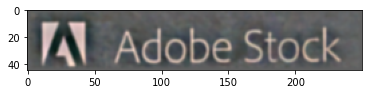

In [8]:
# estimate_watermark.poisson_reconstruct
W_m = poisson_reconstruct(Wm_x, Wm_y)
Wm = W_m - W_m.min()
plt.imshow(PlotImage(W_m))
plt.show()

In [9]:
# get threshold of W_m for alpha matte estimate
alph_est = estimate_normalized_alpha(J, Wm, num_images*2)
alph = np.stack([alph_est, alph_est, alph_est], axis=2)

Estimating normalized alpha using 10 images.


In [10]:
# Jk = E(Wm) + c · αn · E[Ik]
C, est_Ik = estimate_blend_factor(J, Wm, alph)

0.3276142950184657
0.2499261711460981
0.2195171625150035


------------------------------------
Iteration: 0
Step 1


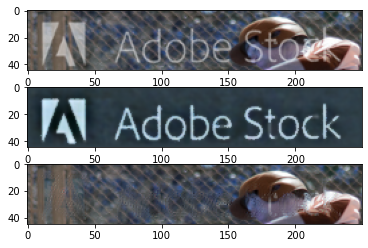

0


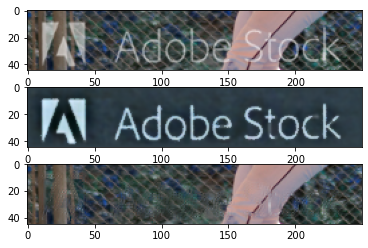

1


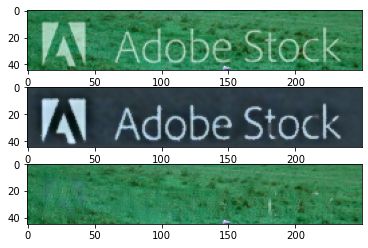

2


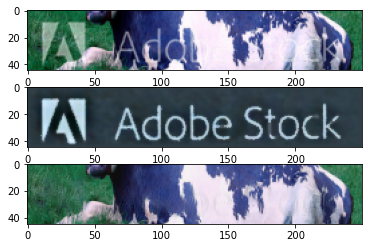

3


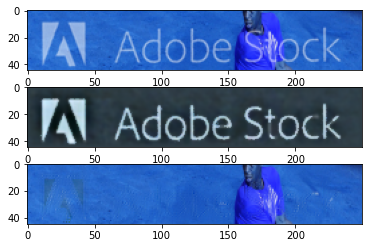

4


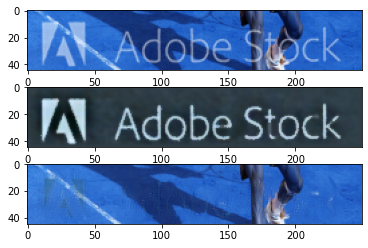

5


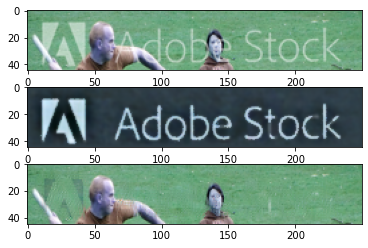

6


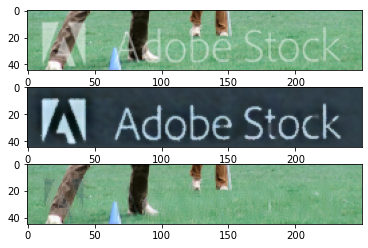

7


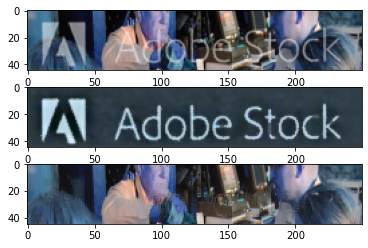

8


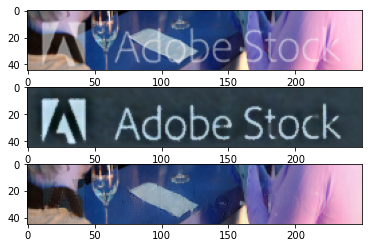

9
Step 2


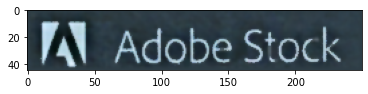

Step 3


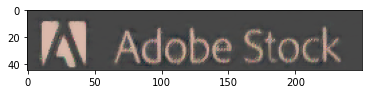

------------------------------------
Iteration: 1
Step 1


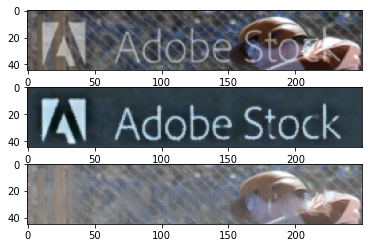

0


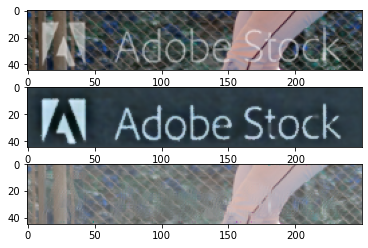

1


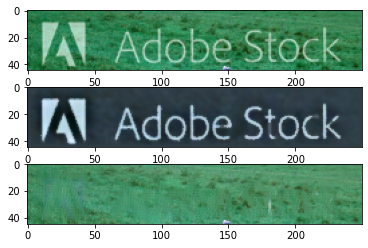

2


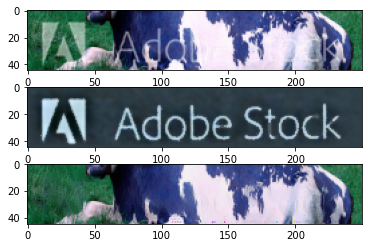

3


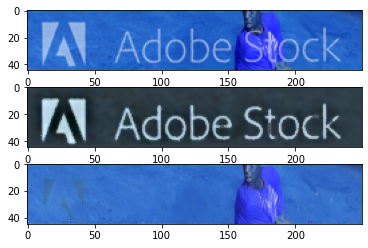

4


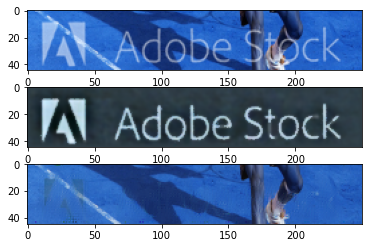

5


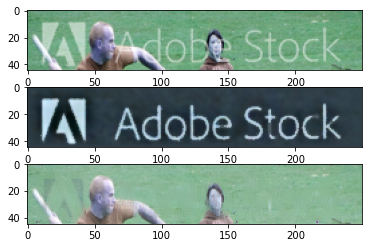

6


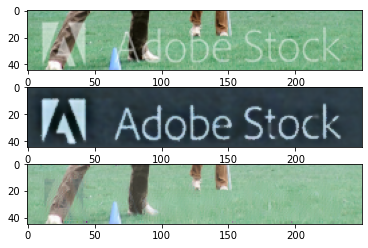

7


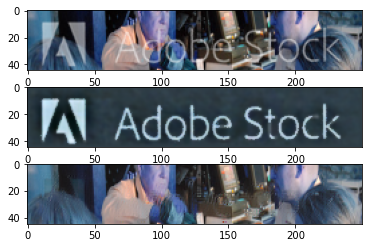

8


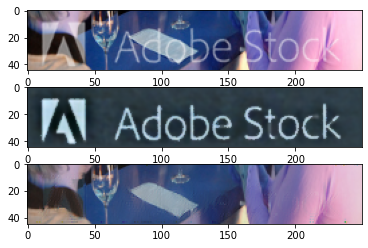

9
Step 2


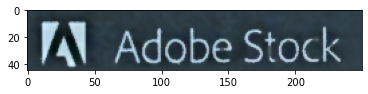

Step 3


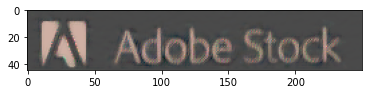

In [11]:
alpha = alph.copy()
for i in range(3):
    alpha[:, :, i] = C[i] * alpha[:, :, i]    # α = c · αn
    
Wm = Wm + alpha * est_Ik      # Est(Wm) = c · αn W − c · αn E[Ik]

W = Wm.copy()
for i in range(3):
    W[:, :, i] /= C[i]

Jt = J[:25]

# now we have the values of alpha, Wm, J
# Solve for all images
Wk, Ik, W, alpha1 = solve_images(Jt, W_m, alpha, W)

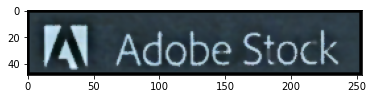

In [12]:
alpha1[alpha1 < 0] = 0
W[W<0] = 0

# add borders
bsize =2
bsize2 = 4
_shape = ((lx+bsize2),(ly+bsize2),3)

W0 = np.zeros(_shape)
W0[bsize:(lx+bsize), bsize:(ly+bsize), :] = W

alpha2 = np.zeros(_shape)
# alpha2[bsize:(lx+bsize), bsize:(ly+bsize), :] = alpha1
alpha2[bsize:(lx+bsize), bsize:(ly+bsize), :] = alpha1

cropped_gx1 = np.zeros(_shape)
cropped_gx1[bsize:(lx+bsize), bsize:(ly+bsize), :] = cropped_gx

plt.imshow(PlotImage(W0))
plt.draw()

In [13]:
# ------------------------------- test ----------------------------------

In [18]:
# number of images in test set
test_num=1
s_n=[]

for i in range(num_w):
    s_n.append((s[i][0]-bsize,s[i][1]-bsize)) 

J_n,file_names = get_cropped_images(
    test_pth+'watermarked', test_num, num_w, s_n, cropped_gx1.shape)

Wk, Ik, W2, alpha3 = get_images(J_n, W0, alpha2)

get the original images
0
1
2
3
4
5
6
7


In [19]:
for i in range(test_num*num_w):
    cv2.imwrite(test_pth+'patch/'+str(i)+'.png',Ik[i])

In [20]:
# join patch and image
_lx = cropped_gx1.shape[0]
_ly = cropped_gx1.shape[1]
_s=s_n

for i in range(1,test_num+1):    
    _img=cv2.imread(test_pth+"watermarked/"+ file_names[i-1])
    out = np.zeros([2*img_shape[0],2*img_shape[1],3]).astype( np.uint8 )
    out[int(img_shape[0]/2):int(3*img_shape[0]/2), int(img_shape[1]/2):int(3*img_shape[1]/2)] = _img[0:img_shape[0],0:img_shape[1]]
    for j in range(num_w):    
        _mark=cv2.imread(test_pth+'patch/'+ str((i-1)*num_w+j)+'.png')
        out[_s[j][0]:_s[j][0]+_lx, _s[j][1]:_s[j][1]+_ly]=_mark

    cv2.imwrite(result_pth+ file_names[i-1],out[int(img_shape[0]/2):int(3*img_shape[0]/2),int(img_shape[1]/2):int(3*img_shape[1]/2)])
    print("success: "+ str(i))
    

success: 1


In [21]:
# save W,alpha,cropped_gx,s to disk
cv2.imwrite(result_pth+'W.png',W)
cv2.imwrite(result_pth+'alpha.png',alpha1)
cv2.imwrite(result_pth+'cropped_gx.png',cropped_gx)
cv2.imwrite(result_pth+'cropped_gy.png',cropped_gy)

f1 = open(result_pth+"s.txt", "w")
f1.write(str(s))
f1.close()